# Timestamp Noise
or - softenning the margins

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

In [7]:
import re
from tqdm import tqdm

In [8]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds

In [9]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [10]:
data = data[data["maid"]==7]

In [11]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [12]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [13]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

Sample two cookies with the same ua

In [9]:
constants = ['brand','model','os', 'osversion', 'browser', 'advertisedbrowser', 'browserversion']

In [37]:
data_groups = data.groupby(constants)['iiqid'].nunique()

In [71]:
sample_specs = data_groups[data_groups > 1].sample().index.to_list()[0]

In [72]:
sample_data = data[data[constants].eq(sample_specs).all(axis=1)].copy()
sample_data.sort_values(by='time', inplace=True)

In [83]:
found = False
limit = 1000
while not found and limit > 0:
    sample_specs = data_groups[data_groups > 1].sample().index.to_list()[0]
    sample_data = data[data[constants].eq(sample_specs).all(axis=1)]
    if sample_data['iiqid'].value_counts()[:2].min() > 10:
        two_frequent = sample_data.loc[sample_data['iiqid'].isin(sample_data['iiqid'].value_counts()[:2].index)].copy()
        two_frequent.sort_values(by='time', inplace=True)
        found = True
    limit -= 1

<Axes: xlabel='time', ylabel='iiqid'>

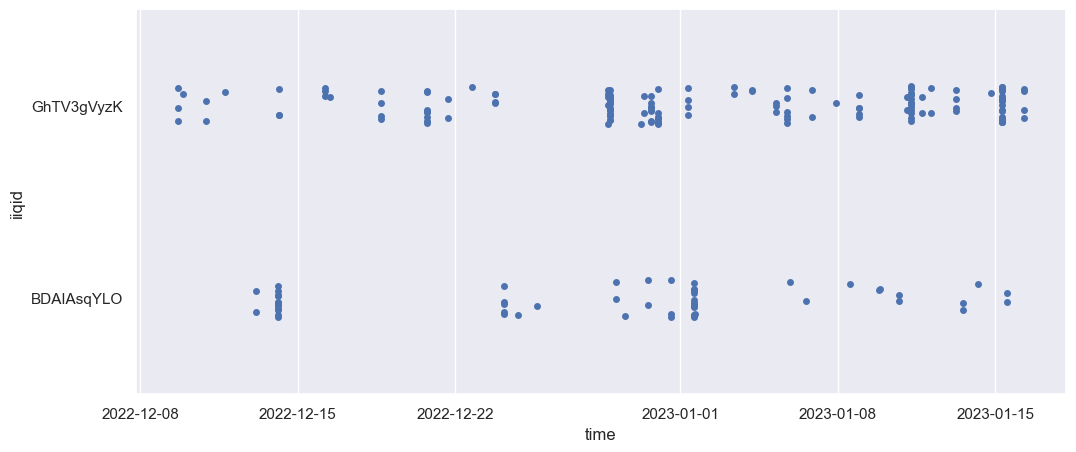

In [95]:
# sns.stripplot(data=two_frequent, x='time', y='browserversion', hue='iiqid')
sns.stripplot(data=two_frequent, x='time', y='iiqid')

In [90]:
serialize_id = {iiq: i for i, iiq in enumerate(two_frequent['iiqid'].unique())}

In [91]:
two_frequent['iiqid_num'] = two_frequent['iiqid'].apply(lambda x: serialize_id[x])

In [105]:
s, inds = lnds(two_frequent['iiqid_num'].values)
not_inds = [i for i in range(len(two_frequent)) if i not in inds]

<Axes: xlabel='time', ylabel='iiqid'>

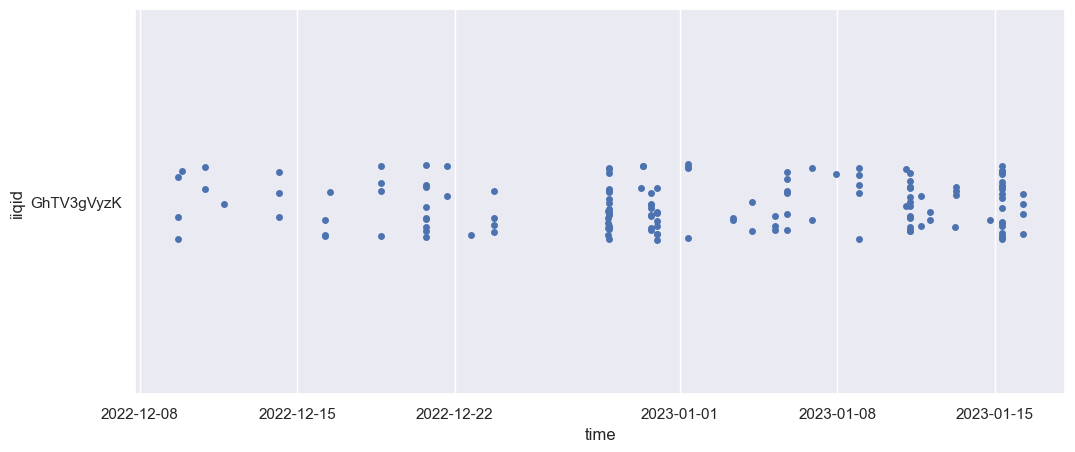

In [104]:
sns.stripplot(data=two_frequent.iloc[inds], x='time', y='iiqid')

[Text(0, 0, 'GhTV3gVyzK'), Text(0, 1, 'BDAIAsqYLO')]

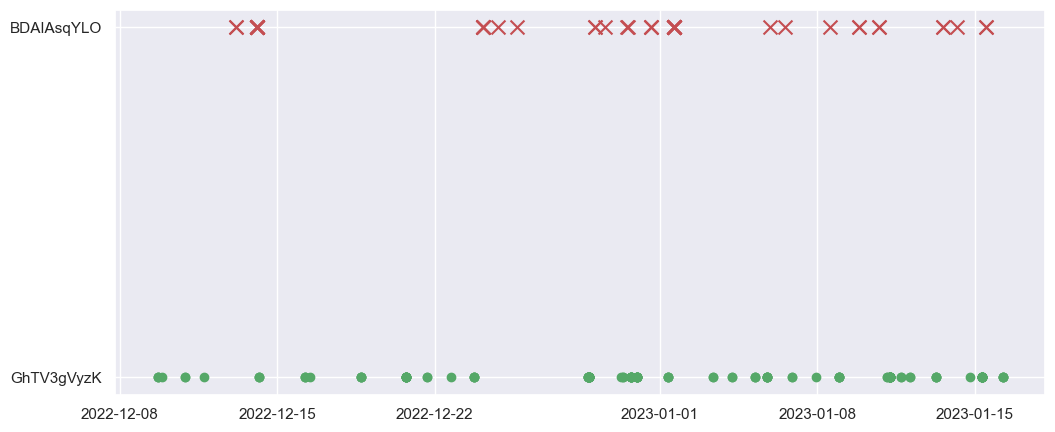

In [111]:
fig, ax = plt.subplots()
ax.scatter(two_frequent['time'].iloc[not_inds], 
           [v for i, v in enumerate(two_frequent['iiqid_num'].values) if i in not_inds], s=100, c='r', marker='x')
ax.scatter(two_frequent.time.iloc[inds], s, c='g', marker='o')
# ax.set_title(f"Cookie's iiqid: {one_cookie_id}")
# ax.set_yticks(range(min(two_frequent['iiqid_num'].values), max(two_frequent['iiqid_num'].values)+1))
ax.set_yticks([0,1])
ax.set_yticklabels(two_frequent['iiqid'].unique())

In [113]:
len(s)/ len(two_frequent)

0.7268292682926829

## Randomize Trial

### Random Pairs

In [19]:
from itertools import combinations
import random

In [10]:
houses = data['hh_id'].unique()
pairs = list(combinations(houses, 2))

In [12]:
sample_size = 2000
random_pairs = random.sample(pairs, sample_size)

In [13]:
pair = random_pairs[0]
pair_data = data[data['hh_id'].isin(pair)].copy()
pair_data.sort_values(by='time', inplace=True)
random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}

In [27]:
noise_of_pairs = {'noise': [], 'size_0': [], 'size_1': []}
for pair in tqdm(random_pairs):
    pair_data = data[data['hh_id'].isin(pair)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
    random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    noise_of_pairs['noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==random_iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==random_iiqid_1))
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

100%|███████████████████████████████████████| 2000/2000 [01:44<00:00, 19.07it/s]


<Axes: xlabel='noise', ylabel='Count'>

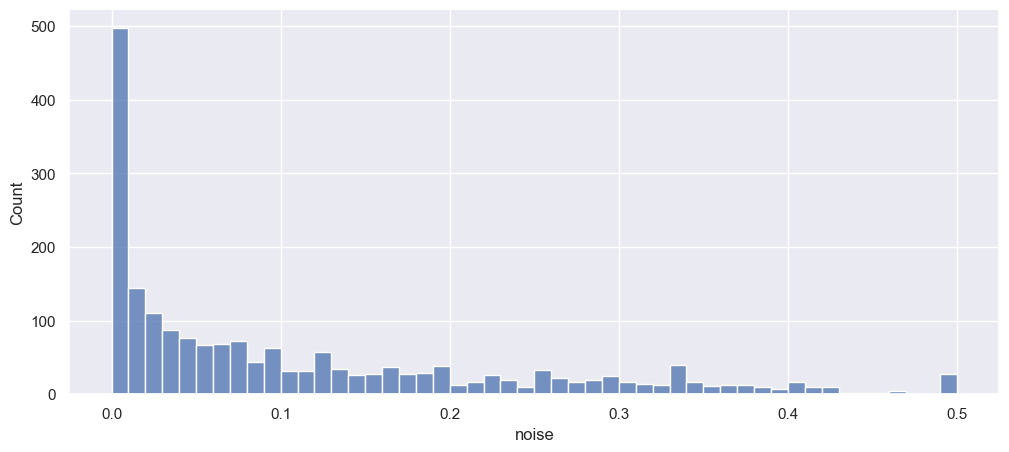

In [28]:
# plt.hist([1-i for i in noise_of_pairs], alpha=0.8, bins=50);
sns.histplot(data=noise_of_pairs, x='noise', bins=50)

In [31]:
noise_of_pairs_df['min_size'] = noise_of_pairs_df[['size_0','size_1']].min(axis=1)

In [43]:
noise_of_pairs_df['max_size'] = noise_of_pairs_df[['size_0','size_1']].max(axis=1)

In [39]:
noise_of_pairs_df['no_noise'] = noise_of_pairs_df['noise']==0

Text(0.5, 1.0, "Corelation of pair's timeline noise")

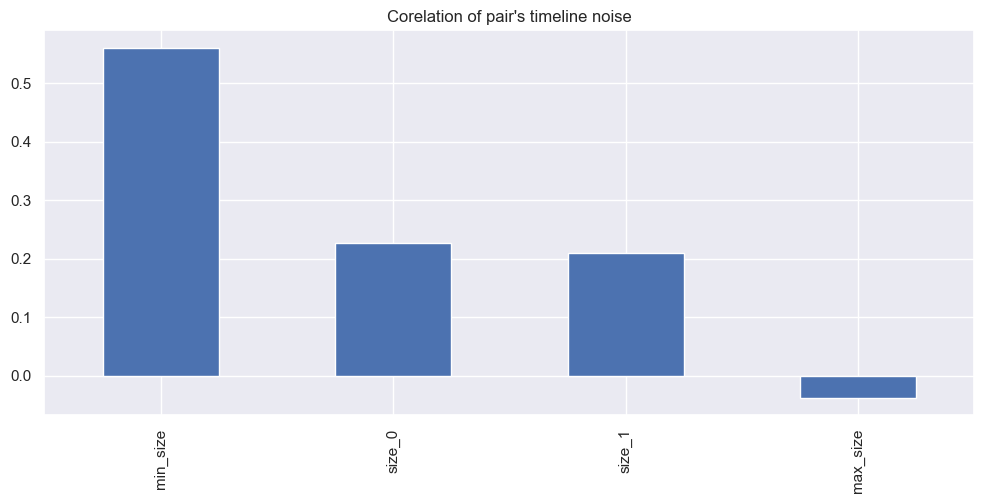

In [86]:
noise_of_pairs_df.corr(method='spearman')['noise'].sort_values(ascending=False)[1:-1].plot.bar()
plt.title("Corelation of pair's timeline noise")

<Axes: xlabel='max_size', ylabel='noise'>

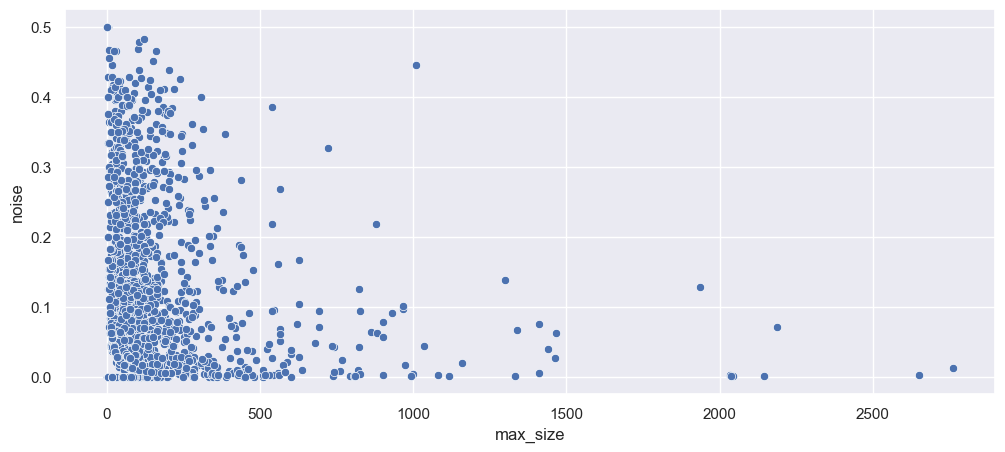

In [53]:
sns.scatterplot(data=noise_of_pairs_df, x='max_size', y='noise')

(1.0, 100.0)

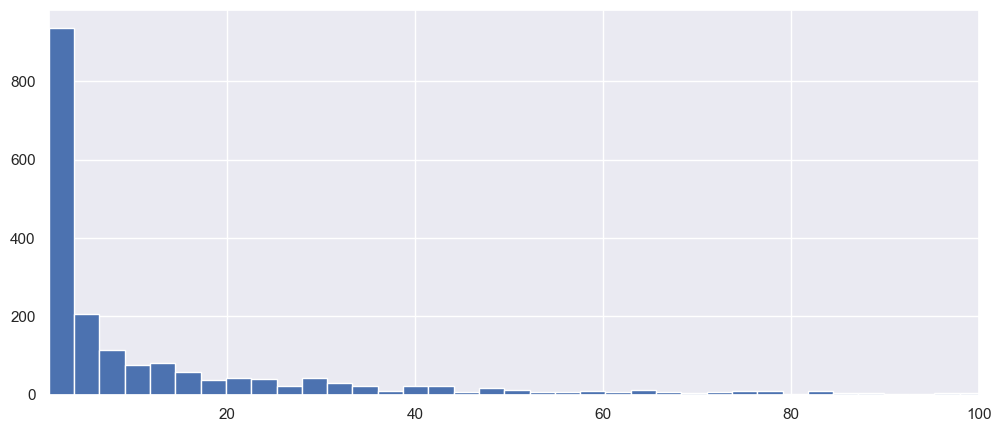

In [95]:
# ax = sns.histplot(data=noise_of_pairs_df, x='min_size', bins=100)
plt.hist(noise_of_pairs_df['min_size'], bins=300)
plt.xlim(1,100)
# plt.xticks(range(1,32));

In [78]:
thresh = 3
n = len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) & (noise_of_pairs_df['noise']==0)])
m = len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh)])
n / m

0.07419898819561552

In [80]:
noise_of_threshold_on_min_size = [len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) & (noise_of_pairs_df['noise']==0)]) / len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh)]) for thresh in range(100)]

In [99]:
import matplotlib.ticker as mtick

Text(0.5, 0, 'Threshold on the minimal size in pair')

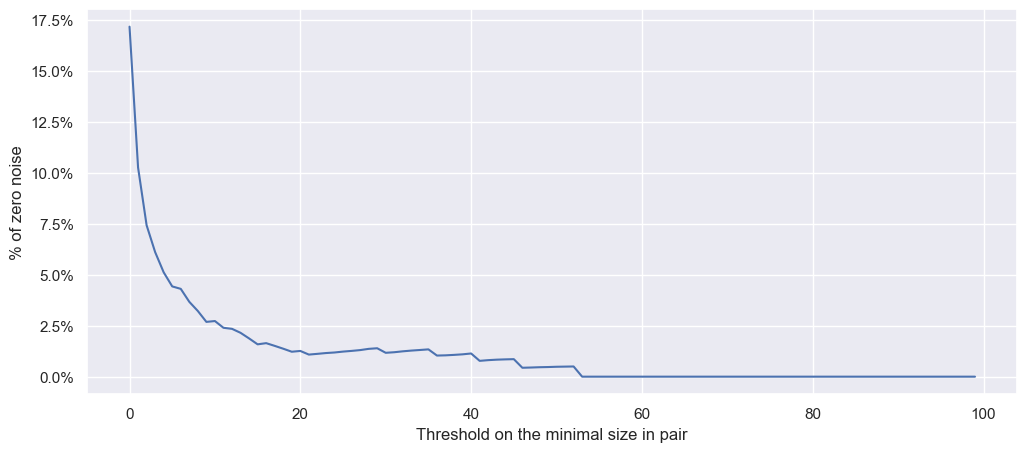

In [108]:
fig, ax = plt.subplots()
ax.plot(noise_of_threshold_on_min_size)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel("% of zero noise")
ax.set_xlabel("Threshold on the minimal size in pair")

<Axes: xlabel='noise', ylabel='Count'>

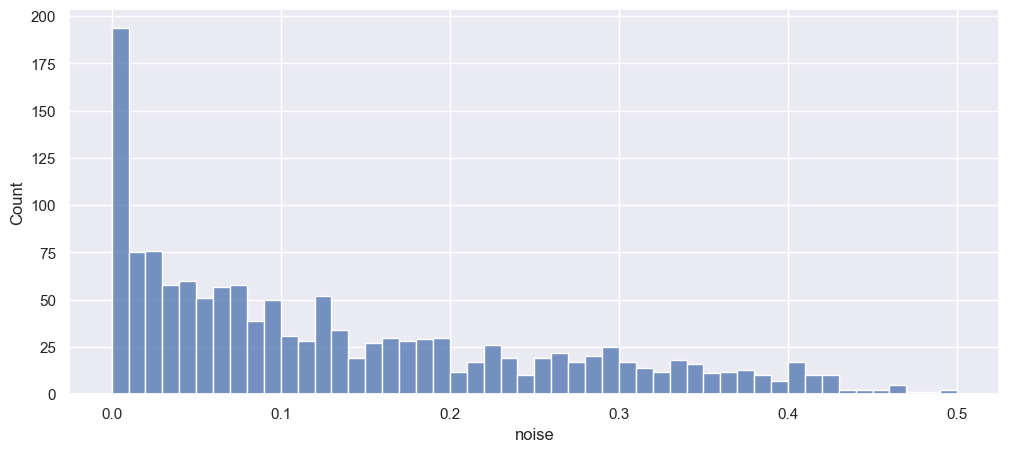

In [73]:
sns.histplot(data=noise_of_pairs_df[noise_of_pairs_df['min_size']>1], x='noise', bins=50)

In [64]:
len(noise_of_pairs_df[noise_of_pairs_df['min_size']==1]) / sample_size 

0.3025

In [20]:
pair = random_pairs[int(np.random.randint(0, len(random_pairs), 1))]
pair_data = data[data['hh_id'].isin(pair)].copy()
pair_data.sort_values(by='time', inplace=True)
random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data)}")
print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_1))/len(pair_data)}")
s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
not_inds = [i for i in range(len(pair_data)) if i not in inds]
print(f"Noise: {1 - len(s) / len(pair_data)}")

First cookie fraction: 0.6818181818181818
First cookie fraction: 0.3181818181818182
Noise: 0.15909090909090906


In [21]:
print(f"Noise: {1 - len(s) / len(pair_data)}")
print(f"Noise: {len(not_inds) / len(inds)}")

Noise: 0.15909090909090906
Noise: 0.1891891891891892


Text(0.5, 1.0, 'Noise: 0.15909090909090906')

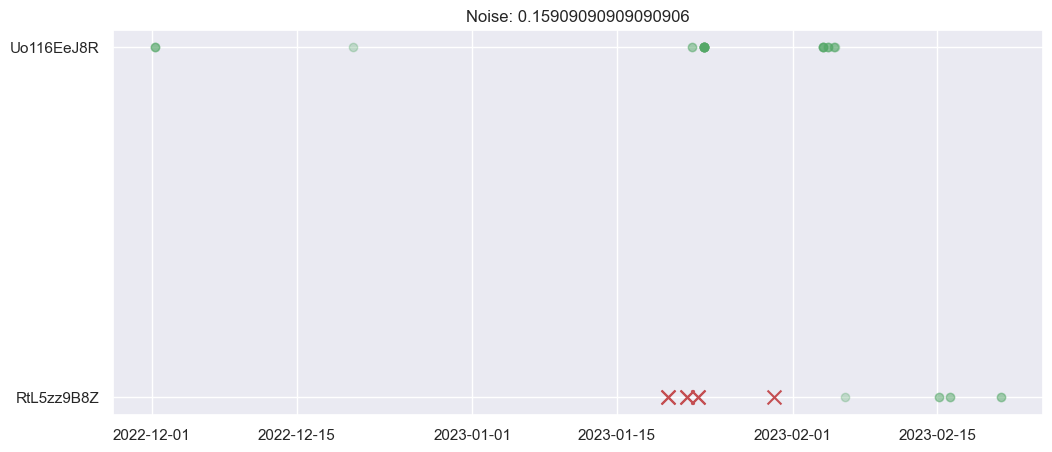

In [22]:
plt.scatter(pair_data['time'].iloc[not_inds], 
           [v for i, v in enumerate(pair_data['iiqid'].values) if i in not_inds], s=100, c='r', marker='x')
plt.scatter(pair_data.time.iloc[inds], 
            [v for i, v in enumerate(pair_data['iiqid'].values) if i in inds], c='g', marker='o', alpha=0.3)
plt.title(f"Noise: {1 - len(s) / len(pair_data)}")

In [16]:
pd.Series([1-i for i in noise_of_pairs]).describe()

count    2000.000000
mean        0.113700
std         0.125814
min         0.000000
25%         0.012658
50%         0.062500
75%         0.181818
max         0.500000
dtype: float64

In [19]:
zeros = [j for j, i in enumerate(noise_of_pairs) if i == 1]
print(len(zeros) / sample_size)

0.161


In [64]:
found = False
limit = 1000
while not found and limit > 0:
    pair = random_pairs[random.sample(zeros, 1)[0]]
    pair_data = data[data['hh_id'].isin(pair)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[0], 'iiqid'].unique())
    random_iiqid_1 = np.random.choice(pair_data.loc[pair_data['hh_id']==pair[1], 'iiqid'].unique())
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data = pair_data[pair_data['iiqid'].isin([random_iiqid_0, random_iiqid_1])]
    # print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data)}")
    # print(f"First cookie fraction: {(sum(pair_data['iiqid']==random_iiqid_1))/len(pair_data)}")
    if 0.9 > (sum(pair_data['iiqid']==random_iiqid_0))/len(pair_data) > 0.1:
        if sum(pair_data['iiqid']==random_iiqid_0) > 3 and sum(pair_data['iiqid']==random_iiqid_1) > 3:
            s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
            not_inds = [i for i in range(len(pair_data)) if i not in inds]
            if len(s)==len(pair_data):
                found = True
    limit -= 1
print(found)
print(f"Noise: {1 - len(s) / len(pair_data)}")

True
Noise: 0.0


In [65]:
house_1, house_2 = pair_data['hh_id'].unique()

Text(0.5, 1.0, 'Noise: 0.0\nHouse 1: aVRPjo5FTT | House 2: niIyWc2rTs')

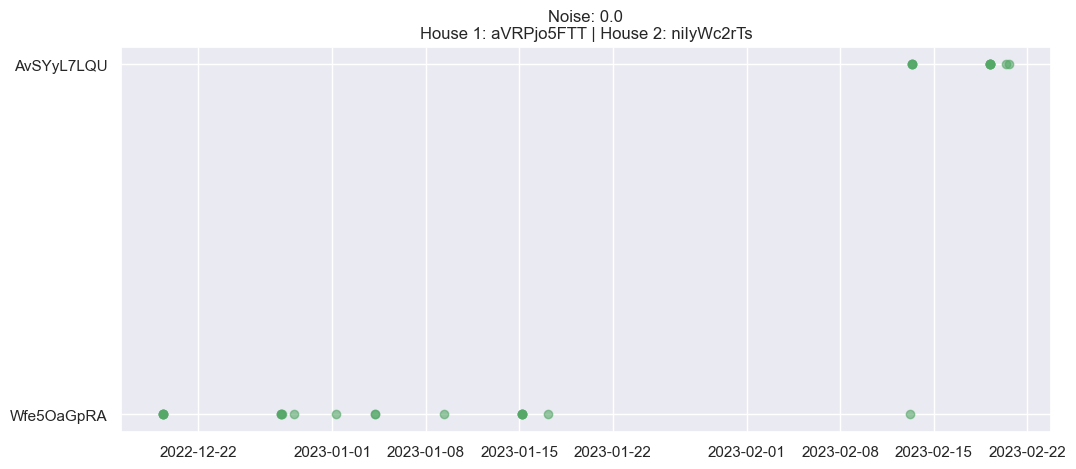

In [66]:
 plt.scatter(pair_data['time'].iloc[not_inds], 
           [v for i, v in enumerate(pair_data['iiqid'].values) if i in not_inds], s=100, c='r', marker='x')
plt.scatter(pair_data.time.iloc[inds], 
            [v for i, v in enumerate(pair_data['iiqid'].values) if i in inds], c='g', marker='o', alpha=0.6)
plt.title(f"Noise: {1 - len(s) / len(pair_data)}\nHouse 1: {house_1} | House 2: {house_2}")

### All pairs with the same constant part

In [ ]:
def overlap(cookies):
    

In [122]:
data_groups = data.groupby(constants)['hh_id'].nunique()

In [126]:
indices = data_groups[data_groups > 1].index.to_list()

In [ ]:
data[data[constants].eq(sample_specs).all(axis=1)].copy()

In [72]:
sample_data = data[data[constants].eq(sample_specs).all(axis=1)].copy()
sample_data.sort_values(by='time', inplace=True)

In [121]:
data.groupby(constants)['hh_id'].nunique()

brand  model   os       osversion  browser        advertisedbrowser    browserversion
acer   b3-a40  android  7.0        chrome mobile  Chrome Mobile        107.0.0.0         1
                                                                       108.0.0.0         2
                                                                       109.0.0.0         2
                                                                       69.0.3497.100     1
                                                  Facebook on Android  7.0               2
                                                                                        ..
zte    z982    android  7.1.1      chrome mobile  Chromium             110.0.5481.65     1
       zr01    android  10         chrome mobile  Chrome Mobile        100.0.4896.127    1
                                                                       108.0.0.0         1
                                                                       109.0.0.0         1
    

### Only lonely cookies

In [14]:
const = ['hh_id',"brand", "model", "os", "browser", "advertisedbrowser"]
grouped_hh = data.groupby(const).agg({'iiqid': ['nunique',pd.Series.mode]})

In [15]:
lonely_hh = grouped_hh[grouped_hh[('iiqid', 'nunique')]==1]

In [16]:
lonely_cookies = lonely_hh['iiqid']['mode'].values

In [17]:
lonely_cookies

array(['6MILYBoI9P', 'vjNRSKwlH4', 'WATS0P8zVm', ..., '2oWL7w8Na8',
       'uo36TXLVcg', '0UXCVZvWch'], dtype=object)

In [18]:
sample_size = 1000
pairs = np.random.choice(lonely_cookies, size=sample_size*2)
pairs = [(pairs[i], pairs[i+1]) for i in range(0, sample_size*2, 2)]

In [137]:
noise_of_pairs = {'noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}
for pair in tqdm(pairs):
    pair_data = data[data['iiqid'].isin(pair)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0, random_iiqid_1 = pair
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}

    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    noise_of_pairs['noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==random_iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==random_iiqid_1))
    noise_of_pairs['first'].append(random_iiqid_0)
    noise_of_pairs['second'].append(random_iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

100%|███████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


<Axes: xlabel='noise', ylabel='Count'>

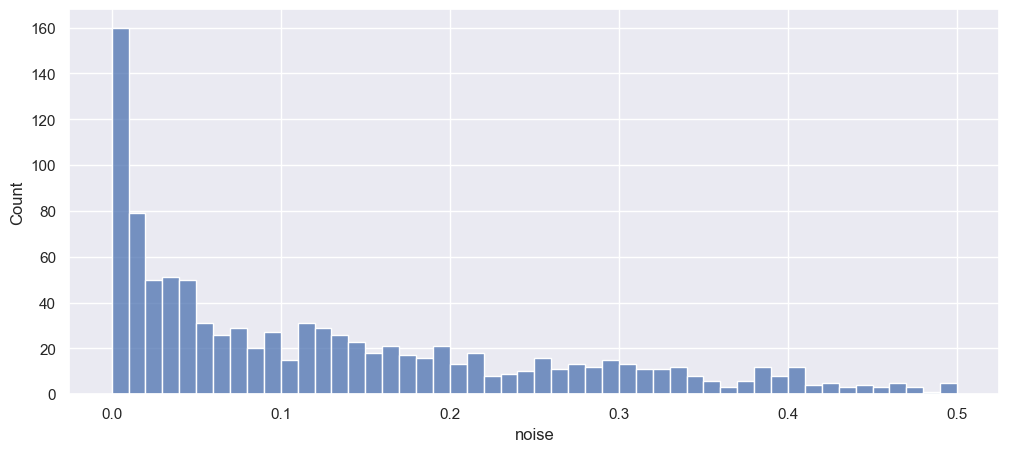

In [138]:
sns.histplot(data=noise_of_pairs_df, x='noise', bins=50)

In [139]:
noise_of_pairs_df['min_size'] = noise_of_pairs_df[['size_0','size_1']].min(axis=1)

In [140]:
noise_of_pairs_df['max_size'] = noise_of_pairs_df[['size_0','size_1']].max(axis=1)

In [141]:
noise_of_pairs_df['no_noise'] = noise_of_pairs_df['noise']==0

Text(0.5, 1.0, "Corelation of pair's timeline noise")

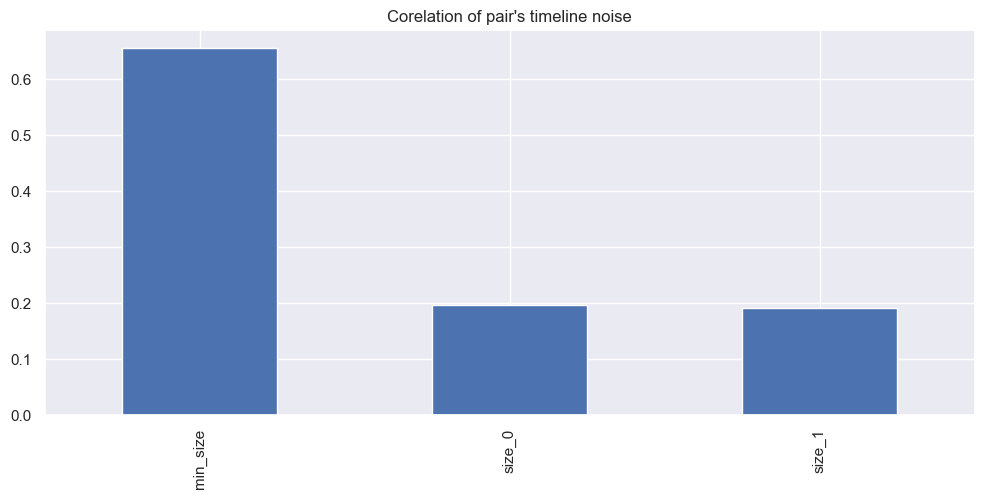

In [142]:
noise_of_pairs_df.select_dtypes(include=np.number).corr(method='spearman')['noise'].sort_values(ascending=False)[1:-1].plot.bar()
plt.title("Corelation of pair's timeline noise")

(0.0, 100.0)

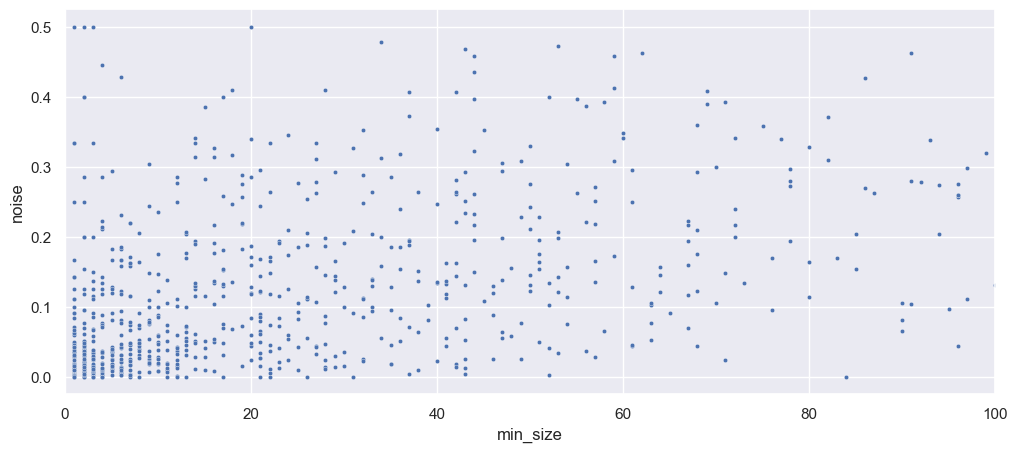

In [143]:
ax = sns.scatterplot(data=noise_of_pairs_df, x='min_size', y='noise', s=10)
ax.set_xlim(0,100)

(1.0, 100.0)

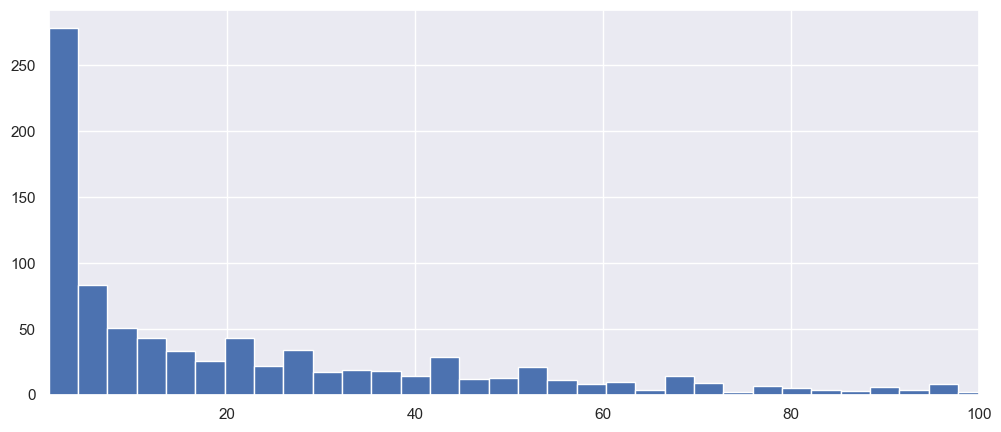

In [156]:
plt.hist(noise_of_pairs_df['min_size'], bins=500)
plt.xlim(1,100)

In [145]:
noise_of_threshold_on_min_size = [len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) & (noise_of_pairs_df['noise']==0)]) / len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh)]) for thresh in range(100)]

In [155]:
thresh = 10
n = len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) & (noise_of_pairs_df['noise']==0)]) 
m = len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh)]) 
print(n)
print(m)
print(n/m)

9
588
0.015306122448979591


In [147]:
import matplotlib.ticker as mtick

Text(0.5, 0, 'Threshold on the minimal size in pair')

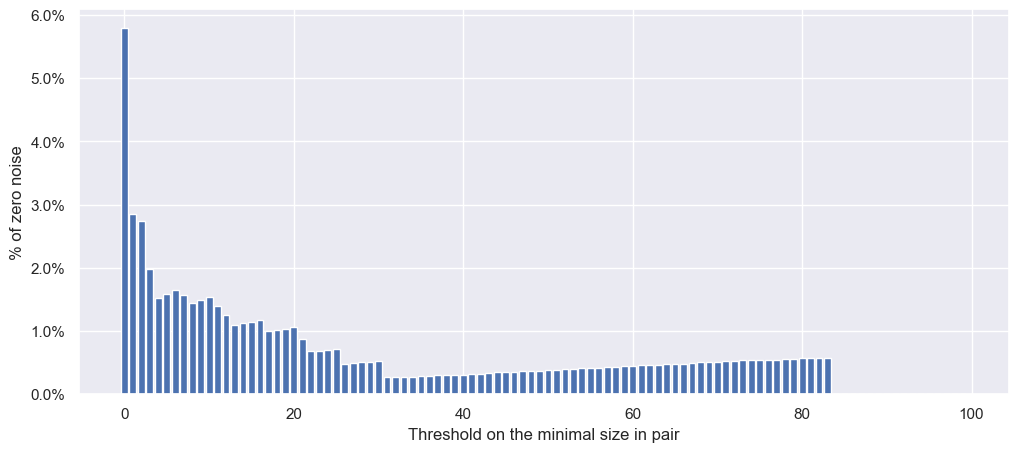

In [148]:
fig, ax = plt.subplots()
ax.bar(range(100), noise_of_threshold_on_min_size)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel("% of zero noise")
ax.set_xlabel("Threshold on the minimal size in pair")

In [150]:
noise_of_threshold_on_min_size[10]

0.015306122448979591

#### The search for the noisy lonely cookies

In [189]:
thresh = 10
no_noise_but_alot = noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) 
                                   & (noise_of_pairs_df['noise']==0)]

In [190]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

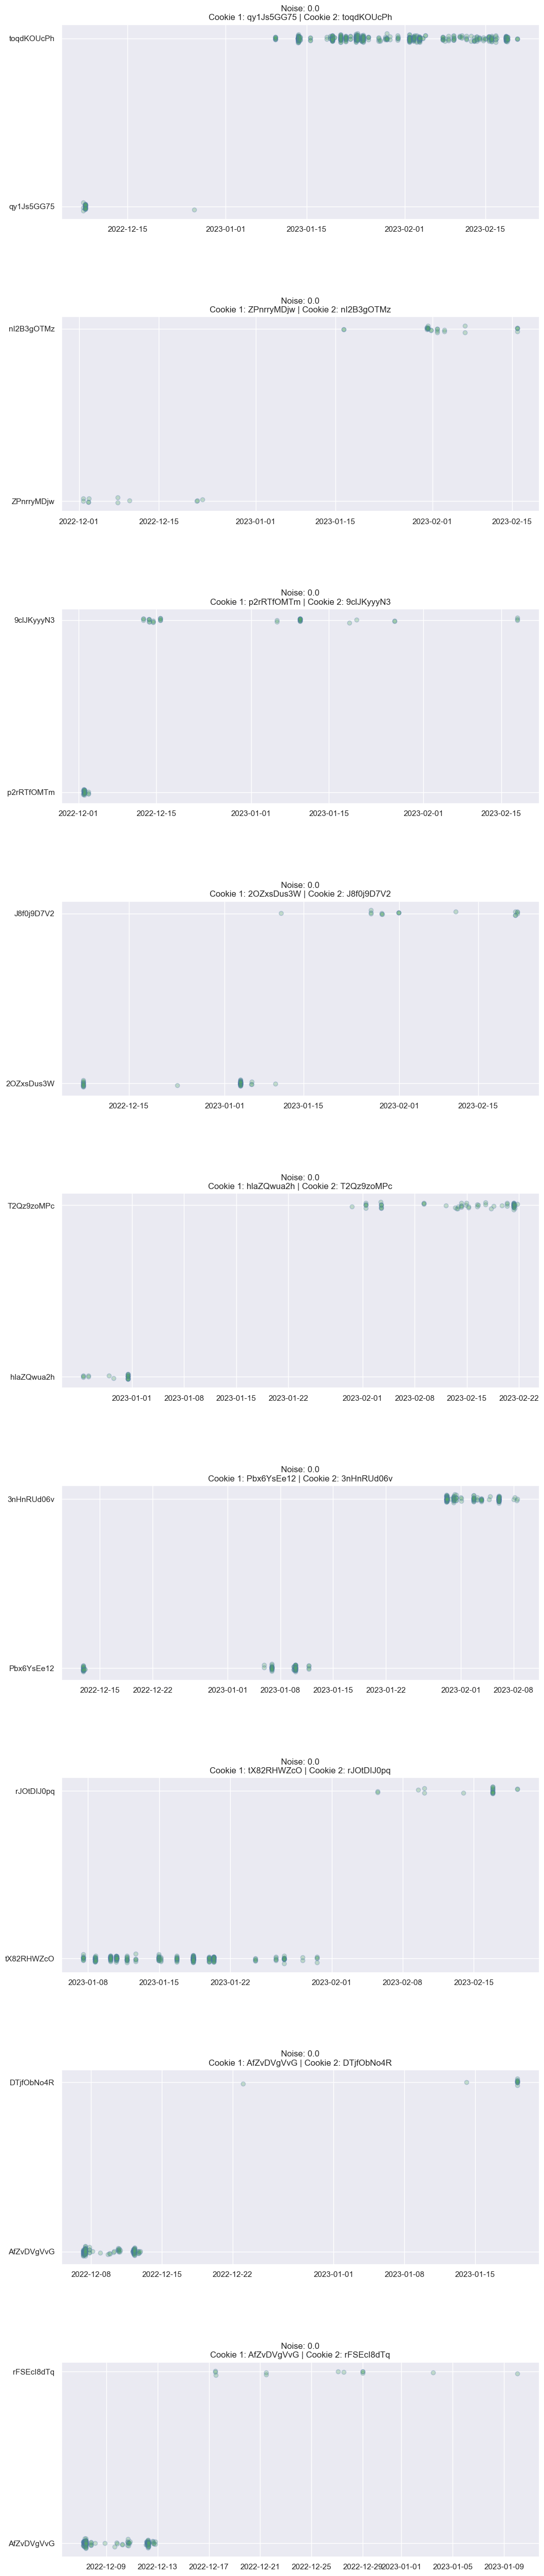

In [231]:
fig, axs = plt.subplots(nrows=len(noisy_but_alot), ncols=1)
fig.set_figheight(64)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)

for i, c in enumerate(no_noise_but_alot[['first', 'second']].values.tolist()):
    ax = axs.flatten()[i]
    pair_data = data[data['iiqid'].isin(c)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0, random_iiqid_1 = c    
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data['iiqid_num'] = pair_data['iiqid'].apply(lambda x: serialize_id[x])
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    deleted_x = pair_data['time'].iloc[not_inds]
    deleted_y = [v for i, v in enumerate(pair_data['iiqid_num'].values) 
                if i in not_inds]
    ax.scatter(deleted_x, deleted_y, c='r', s=15, marker='x')
    ax.scatter(pair_data.time.iloc[inds], rand_jitter(s), 
               edgecolor='b', c='g', alpha=0.3, marker='o')

    ax.set_yticks([0,1])
    ax.set_yticklabels(pair_data['iiqid'].unique())

    ax.set_title(f"Noise: {1 - len(s) / len(pair_data)}\nCookie 1: {random_iiqid_0} | Cookie 2: {random_iiqid_1}")

### Math

A = Both have more than 10 and no colision

B = The cookies are the same

H = Same house

$P(B | A)$

$P(B|A) = \frac{P(A|B) \cdot P(B)}{p(A)}$

Assuming we live in a world with no noise and only have cookies with > 10

$P(B|A) = 1$

#### Again

A = No colision

B = The cookies are the same

H = Same house

$P(\bar{B}|H \wedge A)$

By Bayes

$P(\bar{B}|H \wedge A) = \frac{P(H \wedge A|\bar{B}|)\cdot P(\bar{B})}{P(H \wedge A)}$

$P(\bar{B}|H \wedge A) = \frac{P(H \cap A \cap \bar{B})}{P(H \cap A)}$

Assuming H is true

$P(\bar{B}|A) = \frac{P(A|\bar{B}|)\cdot P(\bar{B})}{P(A)}$

$P(\text{The cookies are different | No collision}) = \frac{P(\text{No collison|The cookies are different })P(\text{The cookies are diffrent})}{P(\text{No collision})}$

### Cookies from the same house

In [195]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [196]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [197]:
filtered = data.groupby('hh_id').filter(has_multiple_ua)

In [199]:
grouped = filtered.groupby(const)['iiqid'].apply(lambda g: np.random.choice(g))

In [200]:
grouped = grouped.groupby(level=0).filter(lambda g: g.nunique() > 1)

In [208]:
two_from_each_houe = grouped.groupby(level=0).apply(lambda g: g.sample(2))

In [212]:
trial_data = two_from_each_houe.reset_index(level=0).drop('hh_id', axis=1).reset_index()

In [234]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [274]:
# house = trial_pairs.index[0]
limit = 10
for house in tqdm(trial_pairs.index):
    print(trial_pairs.loc[house].values)
    limit -=

array(['UVg62Vt8Va', 'WATS0P8zVm'], dtype=object)

In [251]:
noise_of_pairs = {'noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

100%|███████████████████████████████████████| 6691/6691 [33:41<00:00,  3.31it/s]


<Axes: xlabel='noise', ylabel='Count'>

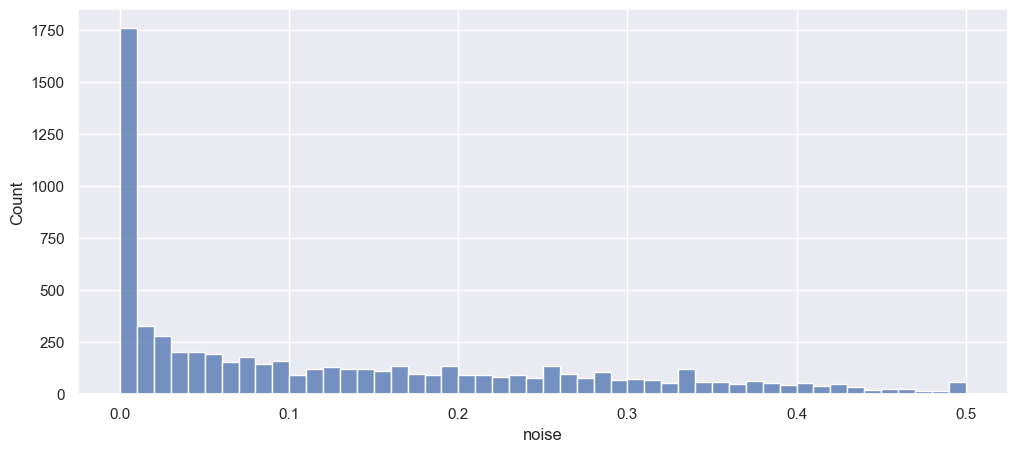

In [252]:
sns.histplot(data=noise_of_pairs_df, x='noise', bins=50)

In [253]:
noise_of_pairs_df['min_size'] = noise_of_pairs_df[['size_0','size_1']].min(axis=1)

In [254]:
noise_of_pairs_df['max_size'] = noise_of_pairs_df[['size_0','size_1']].max(axis=1)

In [255]:
noise_of_pairs_df['no_noise'] = noise_of_pairs_df['noise']==0

Text(0.5, 1.0, "Corelation of pair's timeline noise")

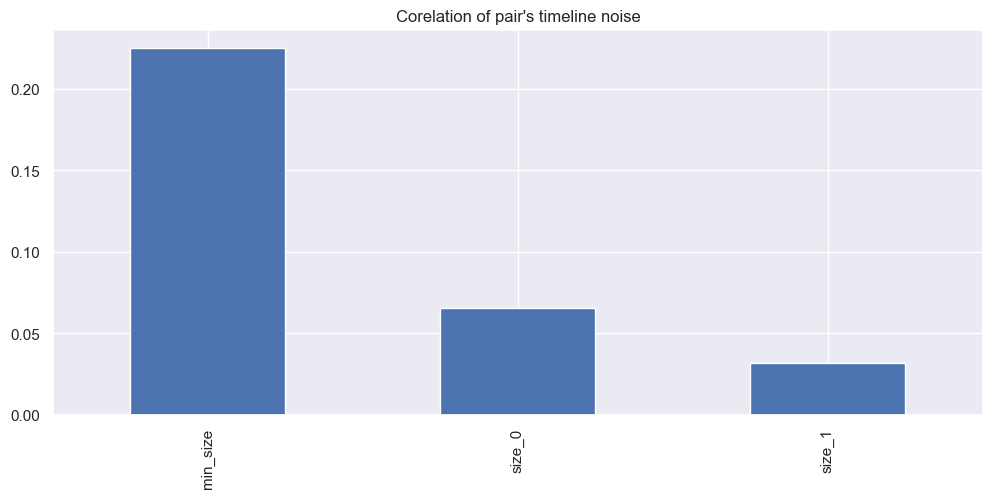

In [258]:
noise_of_pairs_df.select_dtypes(include=np.number).corr(method='spearman')['noise'].sort_values(ascending=False)[1:-1].plot.bar()
plt.title("Corelation of pair's timeline noise")

In [259]:
noise_of_threshold_on_min_size = [len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) & (noise_of_pairs_df['noise']==0)]) / len(noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh)]) for thresh in range(100)]

In [260]:
import matplotlib.ticker as mtick

Text(0.5, 0, 'Threshold on the minimal size in pair')

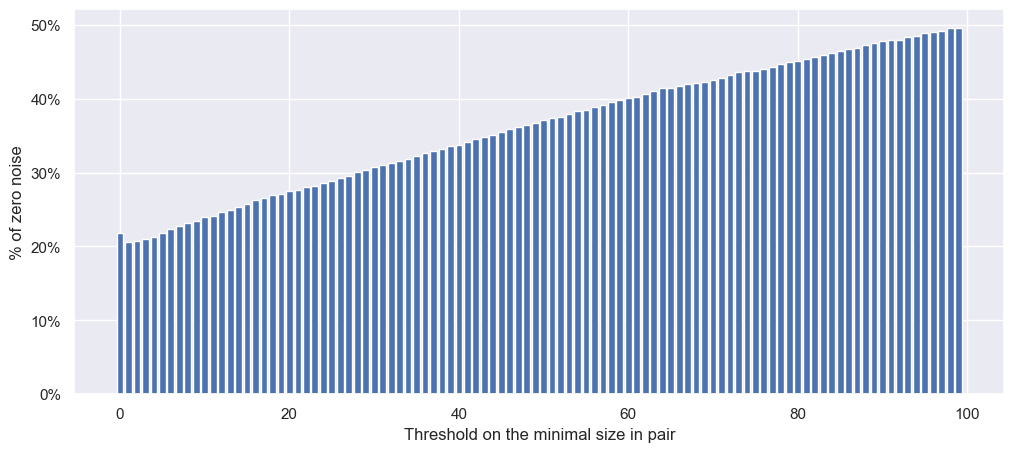

In [261]:
fig, ax = plt.subplots()
ax.bar(range(100), noise_of_threshold_on_min_size)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel("% of zero noise")
ax.set_xlabel("Threshold on the minimal size in pair")

(0.0, 100.0)

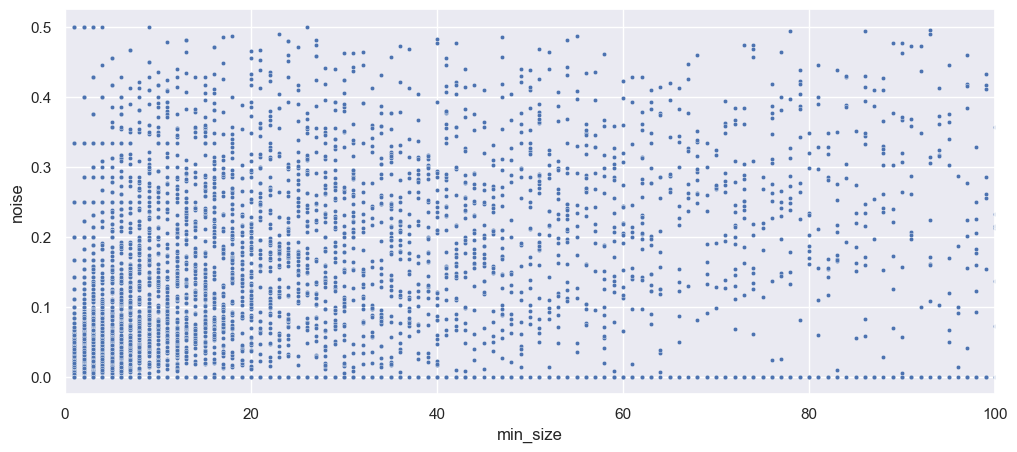

In [262]:
ax = sns.scatterplot(data=noise_of_pairs_df, x='min_size', y='noise', s=10)
ax.set_xlim(0,100)

(1.0, 100.0)

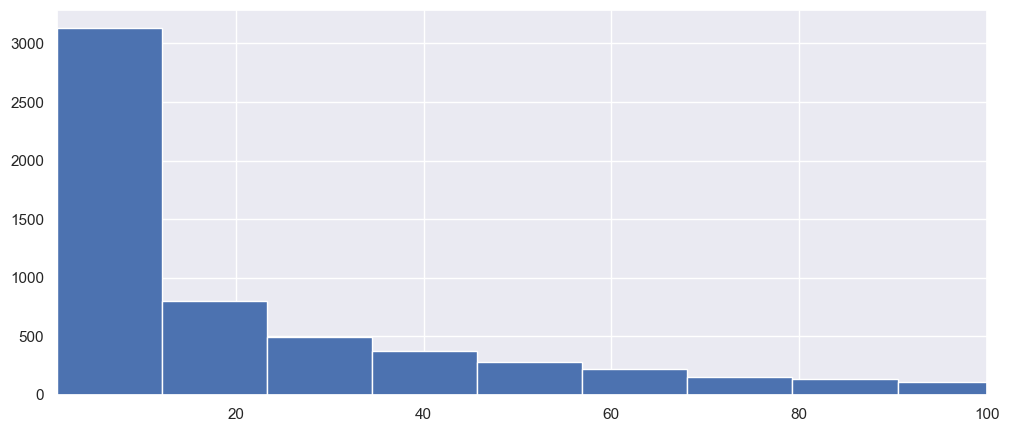

In [263]:
plt.hist(noise_of_pairs_df['min_size'], bins=500)
plt.xlim(1,100)

In [264]:
thresh = 10
no_noise_but_alot = noise_of_pairs_df[(noise_of_pairs_df['min_size']>thresh) 
                                   & (noise_of_pairs_df['noise']==0)]

In [265]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [267]:
len(no_noise_but_alot)

903

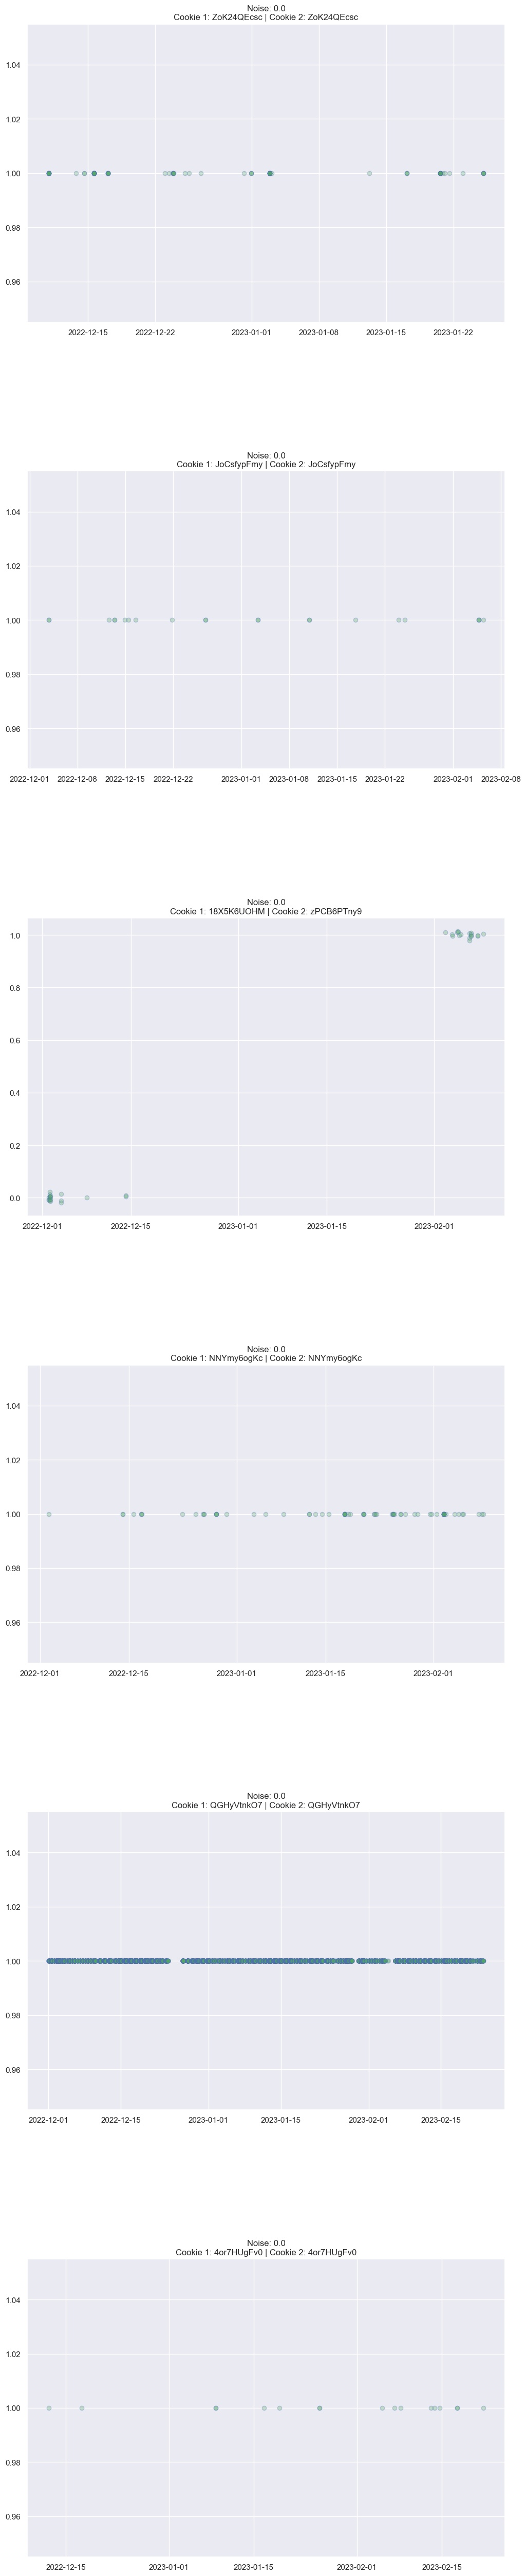

In [270]:
limit = 6
fig, axs = plt.subplots(nrows=limit, ncols=1)
fig.set_figheight(64)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)

for i, c in enumerate(no_noise_but_alot[['first', 'second']].values.tolist()[:limit]):
    ax = axs.flatten()[i]
    pair_data = filtered[filtered['iiqid'].isin(c)].copy()
    pair_data.sort_values(by='time', inplace=True)
    random_iiqid_0, random_iiqid_1 = c    
    serialize_id = {random_iiqid_0: 0, random_iiqid_1: 1}
    pair_data['iiqid_num'] = pair_data['iiqid'].apply(lambda x: serialize_id[x])
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    deleted_x = pair_data['time'].iloc[not_inds]
    deleted_y = [v for i, v in enumerate(pair_data['iiqid_num'].values) 
                if i in not_inds]
    ax.scatter(deleted_x, deleted_y, c='r', s=15, marker='x')
    ax.scatter(pair_data.time.iloc[inds], rand_jitter(s), 
               edgecolor='b', c='g', alpha=0.3, marker='o')

    # ax.set_yticks([0,1])
    # ax.set_yticklabels(pair_data['iiqid'].unique())

    ax.set_title(f"Noise: {1 - len(s) / len(pair_data)}\nCookie 1: {random_iiqid_0} | Cookie 2: {random_iiqid_1}")